Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

# 1. Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pathlib
import pickle

import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from sklearn import metrics

#  for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import PyQt5

# 2. Import Files

## 2.1 Save csv files as pickle

Only run this once to save our csv data as pickle files

In [ ]:
# --> NO NEED TO RUN SAVED AS PICKLE FILES <--
## WEATHER FILES ##

# # AZ PHX Sky Harbor Data #
# AZW_15 = pd.read_csv("./Data/Weather Data/KPHX-15.csv")

# # ENVIMET DATA #
# BPS = []
# Fname = []
# for path in pathlib.Path("./Data/BPS").iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         BPS.append(current_file)
#         Fname.append(path.name.replace('.csv', ''))

# ## Drop last row of EnviMet Data
# for i in range(len(BPS)):
#     BPS[i] = BPS[i].drop(16)

# ## Save files as pickle
# AZW_15.to_pickle("AZW_15.pkl")

# with open('BPS.pkl', 'wb') as f:
#     pickle.dump(BPS, f)

# with open('Fname.pkl', 'wb') as f:
#     pickle.dump(Fname, f)

## 2.2 Reload Pickle

In [2]:
# 1. Load AZ Weather Data (15-min)
weather_station = pd.read_pickle('AZW_15.pkl')

# We will convert these to df depending on the building we choose
# 2. Load 14 envimet bldgData (14 filtered buildings)
with open('BPS.pkl', 'rb') as f:
    envi14 = pickle.load(f)

# 3. Load names of BPS files
with open('Fname.pkl', 'rb') as f:
    Fname = pickle.load(f)



## 2.3 Choose building name to import

In [3]:
##Print Building Names ##
for i in range(len(Fname)):
    print(Fname[i])
    
bldname = input('Enter building name: ')

for i in range(len(envi14)):
    if bldname == Fname[i]:
        # save 
        envi_bldg = envi14[i]

Health Services
Interdisciplinary AB
Bio Design Institute A
Lifescience A_B_D
Bio Design Institute B
COD North
Goldwater
University Club
Engineering Research Ctr
Best Hall
ISTB 1
ISTB 2
ISTB 4
ISTB 5


Enter building name:  Interdisciplinary AB


## 2.4 Create Data Frame

In [4]:
class building:
    
    def __init__(self, bldgname):
        self.bldgname = bldgname
    
    def campusmetabolism(self):
        return pd.read_csv("./Data/ASU 2018/" + bldname + " 2018.csv")

    def envimet(self):
        env = envi_bldg[['Date', 'Time', 'AirTempInFrontOfAllFacades_MEAN', 'RelativeAirHumidityInFrontOfAllFacades_MEAN',
                     'WindSpeedInFrontOfAllFacades_MEAN']]
        
        env = env.rename(columns = {'AirTempInFrontOfAllFacades_MEAN':'Air Temp',
                                    'RelativeAirHumidityInFrontOfAllFacades_MEAN':'Rel Humid',
                                    'WindSpeedInFrontOfAllFacades_MEAN':'Wind Speed'})
        return env


Bldg = building(bldname)
metabol = Bldg.campusmetabolism() # campus metabolism
envimet = Bldg.envimet()          # envimet


# 3. Preprocessing

## 3.1 Formatting Date and Time

### a) Envimet dates

In [6]:
# 1. format time
envimet['Time'] = envimet['Time'].str.replace('.',':')
envimet['Time'] = envimet['Time'].str.replace('01','00')

# convert to 24 hour format
envimet['Time'] = pd.to_datetime(envimet['Time']).dt.strftime('%H:%M')


<ipython-input-6-493917b9433a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  envimet['Time'] = envimet['Time'].str.replace('.',':')


In [7]:
# 2. format date (still in string)
envimet['Date'] = pd.to_datetime(envimet['Date']).dt.strftime('%m/%d/%Y')

In [8]:
# 3. combine date time column as string and set as index
envimet['Date_Time'] = envimet['Date'] + ' ' + envimet['Time']

In [9]:
# 4. Get string type for month and time
envimet['Month'] = envimet['Date_Time'].str[0:2]
envimet['Time'] = envimet['Time'].str.replace(':','')

In [ ]:
# # 5. Get numeric for month hour and minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time)
# microclimate['Month_num'] = microclimate.Date_Time.dt.month
# microclimate['Hour_num'] = microclimate.Date_Time.dt.hour
# microclimate['Minute_num'] = microclimate.Date_Time.dt.minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# # 6. Rearrange columns
# print(list(microclimate.columns))
# microclimate = microclimate[['Date_Time','Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid' ]]

In [10]:
# 5. Rearrange columns
print(list(envimet.columns))
envimet = envimet[['Date_Time','Month','Time', 'Air Temp', 'Rel Humid' ]]

['Date', 'Time', 'Air Temp', 'Rel Humid', 'Wind Speed', 'Date_Time', 'Month']


In [11]:
envimet = envimet.set_index('Date_Time')

### b) Weather Station dates

In [12]:
# 1. Get string type for month and time
weather_station['Month'] = weather_station['Date_Time'].str[0:2]
weather_station['Time'] = weather_station['Date_Time'].str[11:]
weather_station['Time'] = weather_station['Time'].str.replace(':','')

In [13]:
# 2. Get numeric for month hour and minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time)
weather_station['Month_num'] = weather_station.Date_Time.dt.month
weather_station['Hour_num'] = weather_station.Date_Time.dt.hour
weather_station['Minute_num'] = weather_station.Date_Time.dt.minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

In [14]:
# 3. set date time as index
weather_station = weather_station.set_index('Date_Time') 


### c) Building energy dates

In [15]:
metabol.tstamp = pd.to_datetime(metabol.tstamp).dt.strftime('%m/%d/%Y %H:%M')

In [16]:
# remove unwanted columns
metabol = metabol[['tstamp','KW', 'CHWTON']]

In [17]:
# set date time as index
metabol = metabol.set_index('tstamp')


## 3.2 Append Energy Consumption to Weather Station data

In [18]:
weather_station =  pd.concat([metabol, weather_station], axis = 1, join = "inner")


In [19]:
# rearrange column
weather_station = weather_station[['Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid', 'KW','CHWTON' ]]
weather_station 

,Month,Time,Month_num,Hour_num,Minute_num,Air Temp,Rel Humid,KW,CHWTON
01/01/2018 00:00,01,0000,1,0,0,11.0,40.24,138.33,1.09
01/01/2018 00:15,01,0015,1,0,15,11.0,40.24,90.14,0.99
01/01/2018 00:30,01,0030,1,0,30,10.0,43.01,80.49,1.01
01/01/2018 00:45,01,0045,1,0,45,9.0,46.00,84.88,0.90
01/01/2018 01:00,01,0100,1,1,0,9.0,46.00,85.83,0.87
...,...,...,...,...,...,...,...,...,...
12/31/2018 22:00,12,2200,12,22,0,6.0,93.30,124.28,0.00
12/31/2018 22:15,12,2215,12,22,15,5.0,100.00,127.61,0.00
12/31/2018 22:30,12,2230,12,22,30,5.0,100.00,130.48,0.00
12/31/2018 22:45,12,2245,12,22,45,6.0,93.30,133.01,0.00


In [ ]:
# weather_station.to_csv('./Data/weather_st')

# 4. Create June 9th Data 

For both microclimate and weather_station

## 4.1 For Microclimate

We want: month, hour, minute, CHWTON, KW, date, air temp, and real humidity for microclimate June 9th.
We do this by merging with building_energy to get KW and CHWTON on the dates that appear in microclimate data



In [21]:
envimet_j9 = pd.merge(envimet, metabol, left_index = True, right_index = True)
envimet_j9

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,29.288046,12.926082,93.54,2.08
06/09/2018 06:00,06,0600,28.547272,17.865186,117.23,1.22
06/09/2018 07:00,06,0700,29.235614,18.867418,103.66,1.36
06/09/2018 08:00,06,0800,31.330512,18.101223,106.36,2.67
06/09/2018 09:00,06,0900,33.952092,15.256233,105.26,2.71
06/09/2018 10:00,06,1000,35.924490,11.618912,103.63,3.53
06/09/2018 11:00,06,1100,36.924873,9.391644,105.14,4.02
06/09/2018 12:00,06,1200,37.832170,8.080515,103.65,5.69
06/09/2018 13:00,06,1300,38.753659,7.134143,105.62,4.84
06/09/2018 14:00,06,1400,39.469672,6.435761,102.44,4.79


## 4.2 For Weather Station

In [22]:
# 1. Extract june 9th data 
station_j9 = weather_station.iloc[15150:15246]

# 2. Filter time ( only minute 00)
station_j9 = station_j9[ (station_j9['Hour_num'] >= 5) & (station_j9['Hour_num'] <= 20) & (station_j9['Minute_num'] == 0)]


In [23]:
# 3. drop June 9th data on original data
weather_station = weather_station.drop(weather_station.index[15150:15246])

# 4. drop Hour_num and minute_num
weather_station = weather_station.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)
station_j9 = station_j9.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)

In [24]:
station_j9

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,27.0,14.84,93.54,2.08
06/09/2018 06:00,06,0600,26.0,15.74,117.23,1.22
06/09/2018 07:00,06,0700,28.0,17.42,103.66,1.36
06/09/2018 08:00,06,0800,31.0,11.78,106.36,2.67
06/09/2018 09:00,06,0900,33.0,9.06,105.26,2.71
06/09/2018 10:00,06,1000,35.0,7.52,103.63,3.53
06/09/2018 11:00,06,1100,37.0,6.74,105.14,4.02
06/09/2018 12:00,06,1200,39.0,5.19,103.65,5.69
06/09/2018 13:00,06,1300,41.0,4.32,105.62,4.84
06/09/2018 14:00,06,1400,41.0,3.99,102.44,4.79


In [ ]:
# 5. convert index to date time object
weather_station.index = pd.to_datetime(weather_station.index)

# 6. ensure theres no more june 9th data on weather_station data
print(weather_station[(weather_station.index.month == 6) & (weather_station.index.day == 9)])

# convert back
# weather_station.index = pd.to_datetime(weather_station.index).dt.strftime('%m/%d/%Y %H:%M')

In [ ]:
print(weather_station.shape)
print(list(weather_station.columns))


# 5. EDA

## 5.1 Correlation Matrix

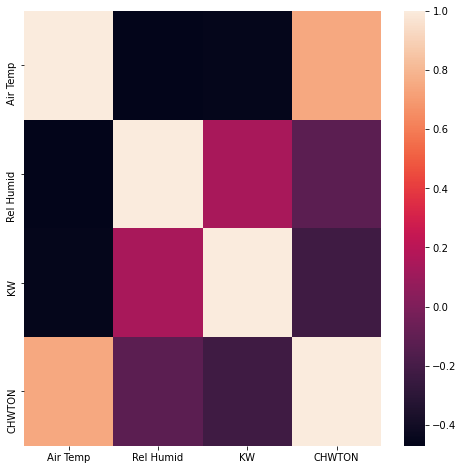

In [25]:
corrMatrix = weather_station.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrMatrix)
plt.show()

## 5.2 Multicolinearity

A simple method to detect multicollinearity in a model is by using something called the variance inflation factor or the VIF for each predicting variable. An acceptable VIF is if it’s less than the max of 10

In [26]:
## Get X
Y = weather_station['CHWTON']

## Get Y
X = weather_station.drop(labels = ['CHWTON'], axis = 1)

In [27]:
X_int = X.drop(labels = ['Month', 'Time'], axis = 1)

In [28]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_int.columns
vif_data["VIF"] = [variance_inflation_factor(X_int.values, i) for i in range(len(X_int.columns))]

In [29]:
vif_data

,feature,VIF
0,Air Temp,3.925219
1,Rel Humid,3.273488
2,KW,6.620458


# 6. Modelling

Scoring:
One one hand, RMSE tells us the typical distance between the predicted value made by the regression model and the actual value.

On the other hand, R2 tells us how well the predictor variables can explain the variation in the response variable.

## 6.1 train & predict

In [30]:
############################ RANDOM FORESTS #################################

# 1. Get train test 
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# 2. Using RandomForestRegressor to make predictions
from sklearn.ensemble import RandomForestRegressor
# - string
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# 3. Get prediction
Y_pred = model.predict(X_test)
ModelPred = pd.DataFrame({'Actual CHWTON':Y_test, 'Predicted CHWTON':Y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

                  Actual CHWTON  Predicted CHWTON
01/01/2018 00:15           0.99            2.5217
01/01/2018 00:30           1.01            1.1789
01/01/2018 00:45           0.90            0.8819
01/01/2018 02:00           1.06            1.0375
01/01/2018 03:15           0.92            0.7448
...                         ...               ...
12/31/2018 17:30           0.00            0.0000
12/31/2018 18:45           0.00            0.0000
12/31/2018 22:15           0.00            0.0051
12/31/2018 22:45           0.00            0.0000
12/31/2018 23:00           0.00            0.0006

[6906 rows x 2 columns]


## 6.2 Score

In [31]:
# 1. RMSE and R2
R2_all = model.score(X_test, Y_test)
RMSE_all = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

# 2.Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\033[1m" + "Feature Importances:" + "\033[0m")
print(feature_imp, "\n")


Feature Importances:
Air Temp     0.539102
Month        0.251560
Time         0.123118
KW           0.046696
Rel Humid    0.039524
dtype: float64 



In [32]:
# 3. create score df
scores_df = pd.DataFrame({"score_type": ["R2", "RMSE"], "RF_allyear": [R2_all, RMSE_all]})
scores_df

,score_type,RF_allyear
0,R2,0.937572
1,RMSE,0.896675


# 7. June 9th Prediction

## 7.1 Weather Station prediction

In [33]:
# 1. Get X and Y (all test)
X_j9 = station_j9.drop(labels = ['CHWTON'], axis = 1)

# 2. Get Y
Y_actual_j9 = station_j9['CHWTON']

# 3. Get Y_pred
Y_pred_j9 = model.predict(X_j9)

# 4. Score
R2_j9 = model.score(X_j9, Y_actual_j9)
RMSE_j9 = np.sqrt(metrics.mean_squared_error(Y_actual_j9, Y_pred_j9))

# 5. Append score to df
score_j9_AZ = [R2_j9, RMSE_j9]
scores_df['RF_j9_AZ'] = score_j9_AZ

scores_df

,score_type,RF_allyear,RF_j9_AZ
0,R2,0.937572,0.876395
1,RMSE,0.896675,0.491681


## 7.2 Microclimate prediction

In [37]:
# 1. Get X
X_j9_envi = envimet_j9 .drop(labels = ['CHWTON'], axis = 1)

# 2. Get Y_pred
Y_pred_j9_envi = model.predict(X_j9_envi)

# 3. Score
R2_j9_envi = model.score(X_j9_envi, Y_actual_j9)
RMSE_j9_envi = np.sqrt(metrics.mean_squared_error(Y_actual_j9, Y_pred_j9_envi))

# 4. append to score df
score_j9_envi = [R2_j9_envi, RMSE_j9_envi]
scores_df['RF_j9_micro'] = score_j9_envi
scores_df

,score_type,RF_allyear,RF_j9_AZ,RF_j9_micro
0,R2,0.937572,0.876395,0.854852
1,RMSE,0.896675,0.491681,0.532807


In [39]:
Pred = pd.DataFrame({'Actual':Y_actual_j9,'Baseline Predictions (AZW)': Y_pred_j9, 'Microclimate Predictions': Y_pred_J9_envi})
Pred

,Actual,Baseline Predictions (AZW),Microclimate Predictions
06/09/2018 05:00,2.08,1.5679,1.8661
06/09/2018 06:00,1.22,1.2942,1.7071
06/09/2018 07:00,1.36,1.9569,2.1295
06/09/2018 08:00,2.67,2.6329,2.7463
06/09/2018 09:00,2.71,2.5130,3.4207
06/09/2018 10:00,3.53,3.4021,3.8307
06/09/2018 11:00,4.02,4.1991,4.1574
06/09/2018 12:00,5.69,4.2866,4.4810
06/09/2018 13:00,4.84,4.9148,4.6787
06/09/2018 14:00,4.79,5.0062,4.8336


# 8. Hypothesis Test

([<matplotlib.axis.XTick at 0x7fcfbc297430>,
 [Text(1, 0, 'Baseline_pred'), Text(2, 0, 'Microclimate_pred')])

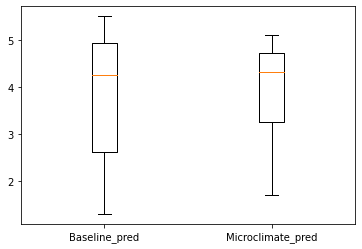

In [41]:
plt.boxplot([Y_pred_j9, Y_pred_j9_envi])
plt.xticks([1,2],['Baseline_pred', 'Microclimate_pred'])

In [43]:
print(Y_pred_j9.mean())
print(Y_pred_j9_envi.mean())
print('mu:', Y_pred_j9.mean()- Y_pred_j9_envi.mean())

3.8306562500000005
3.8565812500000014
mu: -0.025925000000000864


## Two-Sample T Test


mean differences in CHWTON = $ \mu_{baseline} - \mu_{microclimate} = 3.83065-3.866 = -0.03567 $ 

$ H_0: $ Mean of CHWTON in baseline and microclimate are the same

$ H_1: $ Mean of CHWTON in baseline and microclimate are NOT the same

## 8.1 calculate standard deviation

In [45]:
# 1.variance
var_baseline = Y_pred_j9.var(ddof = 1)
var_micro = Y_pred_j9_envi.var(ddof = 1)
print(var_baseline, var_micro)

2.050340138625001 1.326461897625002


In [47]:
# 2. standard deviation
s = np.sqrt((var_baseline + var_micro)/2)
s

1.299384861434441

## 8.2 calculate T-statistic

In [49]:
import scipy.stats as stats
t_stat, p_val = stats.ttest_ind(Y_pred_j9, Y_pred_j9_envi, equal_var=False)
print('t statistics: ', t_stat)
print('p value: ', p_val)

t statistics:  -0.05643206673048272
p value:  0.9553889066821224


P value is not less that 0.05. We cannot reject the null hypothesis. There is no significant difference between the transaction amount of fraud and non fraudulent transaction

# 9. Plot

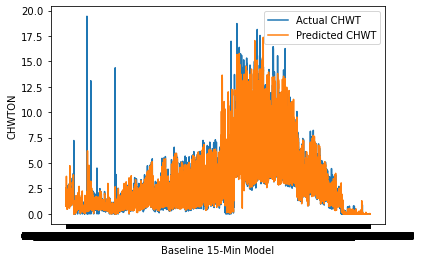

In [50]:
####### Plotting Baseline Model for all 2018 15-min Data #######

## This is a big graph, will be slow to run but gives visual of prediction accuracy
# %matplotlib qt
plt.xlabel('Baseline 15-Min Model')
plt.ylabel('CHWTON')
plt.plot(ModelPred['Actual CHWTON'], label = 'Actual CHWT')
plt.plot(ModelPred['Predicted CHWTON'], label = 'Predicted CHWT')
plt.legend()
plt.show()

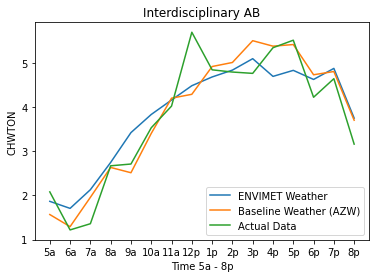

In [51]:
#  Plotting ENVI-met vs AZW vs Actual Data for June 9 from 5a - 8p

positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
labels = ['5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p']

# plot EnviMet vs AZ_Weather results
plt.xlabel('Time 5a - 8p')
plt.ylabel('CHWTON')
plt.xticks(positions, labels)
plt.plot(Pred['Microclimate Predictions'], label = 'ENVIMET Weather')
plt.plot(Pred['Baseline Predictions (AZW)'], label = 'Baseline Weather (AZW)')
plt.plot(Pred['Actual'], label = 'Actual Data')
plt.title('Interdisciplinary AB')
plt.legend()

## show graphs
plt.show()

# 10. Save DF

## 10.1 Weather Station string


In [ ]:
# weather_station.to_csv('./Data/weather_st2')

## 10.2 June 9th Weather St


In [ ]:
# weather_st_June_9.to_csv('./Data/weather_j9')

In [ ]:
# scores_df.to_csv('./Data/score')